In [1]:
import pandas as pd
def get_dataframes():
    dataframes=pd.read_excel("com_Nas_por_campo_Todas_Tabelas_Flu_de_2010_a_2019_com_os_63_campos_da_Intersecao_de_Todos_e 244774_Amostras.xlsx")
    dataframes["NT_DT"] = pd.to_datetime(dataframes['DT_NOTIFIC'], errors = 'coerce')
    dataframes["NT_DT"] = dataframes['NT_DT'].map(lambda x: x.year)
    return dataframes

In [2]:
def convert_uf(uf):
    if uf == "RO":
        return 11
    elif uf == "AC":
        return 12
    elif uf == "AM":
        return 13
    elif uf == "RR":
        return 14
    elif uf == "PA":
        return 15
    elif uf == "AP":
        return 16
    elif uf == "TO":
        return 17
    elif uf == "MA":
        return 21
    elif uf == "PI":
        return 22
    elif uf == "CE":
        return 23
    elif uf == "RN":
        return 24
    elif uf == "PB":
        return 25
    elif uf == "PE":
        return 26
    elif uf == "AL":
        return 27
    elif uf == "SE":
        return 28
    elif uf == "BA":
        return 29
    elif uf == "MG":
        return 31
    elif uf == "ES":
        return 32
    elif uf == "RJ":
        return 33
    elif uf == "SP":
        return 35
    elif uf == "PR":
        return 41
    elif uf == "SC":
        return 42
    elif uf == "RS":
        return 43
    elif uf == "MS":
        return 50
    elif uf == "MT":
        return 51
    elif uf == "GO":
        return 52
    elif uf == "DF":
        return 53
    else:
        return int(uf)

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
def label_regions(df):
    regions = [["53","52","50","51"],["16","12","13","15","11","14","17"],["27","29","23","21","25","22","26","24","28"],["32","31","33","35"],["43","42","41"]]

    df['region-centro-oeste'] = df["UF_NOT"].isin(regions[0]) #centro-oeste
    df['region-norte'] = df["UF_NOT"].isin(regions[1]) #norte
    df['region-nordeste'] = df["UF_NOT"].isin(regions[2]) #nordeste
    df['region-sudeste'] = df["UF_NOT"].isin(regions[3]) #sudeste
    df['region-sul'] = df["UF_NOT"].isin(regions[4]) #sul
    return df

In [5]:
def fill_nan_values(df, variable):
    result_df = df.copy()
    result_df[variable] = result_df[variable].fillna(result_df[variable].mode()[0])
    return result_df

def ignored_to_nan(df, variable):
    df[variable] = df[variable].map(lambda x: np.nan if x == 9 else x)
    return df.copy()

In [6]:
def shuffle_rows(df, variable):
    result_df = df.copy()
    result_df[variable] = result_df.sample(frac = 1.0).copy()[variable].values
    return result_df.sample(frac = 1.0).copy()

In [7]:
import numpy as np
from datetime import timedelta
def clean_df(df):
    df['VACINA'] = df['VACINA'].map(lambda x: np.nan if x == 9 else x)
    df['ANTIVIRAL'] = df['ANTIVIRAL'].map(lambda x: np.nan if x == 9 else x)
    df['PNEUMOPATI'] = df['PNEUMOPATI'].map(lambda x: np.nan if x == 9 else x)
    df['CARDIOPATI'] = df['CARDIOPATI'].map(lambda x: np.nan if x == 9 else x)
    # removing NaN
    #df_clean = df[(df['EVOLUCAO'].notna() & df['SG_UF_NOT'].notna() & df['VACINA'].notna() & df['ANTIVIRAL'].notna() & df['PNEUMOPATI'].notna() & df['CARDIOPATI'].notna())].copy()
    fill_na_fileds = ['EVOLUCAO', 'SG_UF_NOT', 'VACINA', 'ANTIVIRAL', 'PNEUMOPATI', 'CARDIOPATI']
    for i in fill_na_fileds:
        df = ignored_to_nan(df, i)
        df = fill_nan_values(df, i)
    df_clean = df.copy()
    
    
    df_clean['TEMVACINA'] = df_clean['VACINA'].map(lambda x: False if x == 2 else True)
    
    df_clean['USOANTIVIRAL'] = df_clean['ANTIVIRAL'].map(lambda x: False if x == 1 else True)
    
    df_clean['CARDIOPATI'] = df_clean['CARDIOPATI'].map(lambda x: True if x == 1 else False)
    df_clean['PNEUMOPATI'] = df_clean['PNEUMOPATI'].map(lambda x: True if x == 1 else False)
    
    df_clean['MORTE'] = df_clean['EVOLUCAO'].map(lambda x: True if x == "2" or x == "4" or x == 2.0 or x == 4.0 else False)
    df_clean['IDADE'] = (pd.to_datetime(df_clean['DT_NOTIFIC'], errors = 'coerce') - pd.to_datetime(df_clean['DT_NASC'], errors = 'coerce')) / timedelta(days=365)
    df_clean['MAISIDADE'] = df_clean['IDADE'].map(lambda x: True if x > 80 else False)
    df_clean['UF_NOT'] = df_clean['SG_UF_NOT'].map(lambda x: convert_uf(x))
    df_clean['MULHER'] = df_clean['CS_SEXO'].map(lambda x: True if x == "F" else False)
    label_regions(df_clean)
    return df_clean


In [8]:
def load_dataframes(df):
    sensitive_vars = ["MULHER", "MAISIDADE", "region-centro-oeste", "region-norte", "region-nordeste", "region-sudeste", "region-sul", "TEMVACINA", "MORTE", "USOANTIVIRAL", "PNEUMOPATI", "CARDIOPATI"]
    dataframes = []
    dff = clean_df(df)
    dates = [2010.0, 2011.0, 2012.0, 2013.0, 2014.0, 2015.0, 2016.0, 2017.0, 2018.0, 2019.0]
    for i in dates:
        dataframes.append(dff[dff["NT_DT"] == i][sensitive_vars])
    dataframes[0] = dataframes[1]
    return dataframes

In [9]:
raw_df = get_dataframes()


In [10]:
df_processed = load_dataframes(raw_df.copy())
df = df_processed[6].dropna() #TODO check with 5 only e use complete

In [11]:
sensitive_vars = ["MULHER", "MAISIDADE", "region-centro-oeste", "region-norte", "region-nordeste", "region-sudeste", "region-sul", "TEMVACINA", "MORTE", "USOANTIVIRAL", "PNEUMOPATI", "CARDIOPATI"]
warnNonBinary = set()
for j in sensitive_vars:
    for i in df_processed:
        if(len(i.dropna()[j].value_counts()) > 2):
            warnNonBinary.add(j)
print(f"Non binary varables {warnNonBinary}")
df.head()

Non binary varables set()


,MULHER,MAISIDADE,region-centro-oeste,region-norte,region-nordeste,region-sudeste,region-sul,TEMVACINA,MORTE,USOANTIVIRAL,PNEUMOPATI,CARDIOPATI
39247,True,False,False,False,False,True,False,False,False,True,False,False
39727,False,False,False,False,False,True,False,False,False,True,False,False
40044,True,False,False,False,False,True,False,False,False,False,False,False
45226,False,False,False,False,False,True,False,True,True,True,False,False
45346,False,False,False,False,False,True,False,False,False,True,False,False


In [12]:
# Use numpy to convert to arrays
import numpy as np
# mortes are the values we want to predict
mortes = np.array(df['MORTE'])
# Remove the mortes from the features
# axis 1 refers to the columns
df_drop= df.drop('MORTE', axis = 1)
# Saving feature names for later use
feature_list = list(df_drop.columns)
# Convert to numpy array
df_np = np.array(df_drop)

df_vacinados = df[df["TEMVACINA"]]

# mortes are the values we want to predict
mortes_v = np.array(df_vacinados['MORTE'])
# Remove the mortes from the features
# axis 1 refers to the columns
df_drop_v= df_vacinados.drop('MORTE', axis = 1)
# Saving feature names for later use
feature_list_v = list(df_drop_v.columns)
# Convert to numpy array
df_np_v = np.array(df_drop_v)


In [13]:
raw_train_features, test_features, raw_train_mortes, test_mortes = train_test_split(df_np, mortes, test_size = 0.20, random_state = 42)

train_features, valida_features, train_mortes, valida_mortes = train_test_split(raw_train_features, raw_train_mortes, test_size = 0.20, random_state = 42)



raw_train_features_v, test_features_v, raw_train_mortes_v, test_mortes_v = train_test_split(df_np_v, mortes_v, test_size = 0.20, random_state = 42)

train_features_v, valida_features_v, train_mortes_v, valida_mortes_v = train_test_split(raw_train_features_v, raw_train_mortes_v, test_size = 0.20, random_state = 42)



In [14]:
#train_features.shape

In [15]:
from sklearn.ensemble import RandomForestClassifier
# Instantiate model with 1000 decision trees
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42, oob_score = True)
# Train the model on training data
rf.fit(train_features, train_mortes);

# Instantiate model with 1000 decision trees
rf_v = RandomForestClassifier(n_estimators = 1000, random_state = 42, oob_score = True)
# Train the model on training data
rf_v.fit(train_features_v, train_mortes_v);

In [16]:
# Use the forest's predict method on the test data
predictions = rf.predict(valida_features)
# Calculate the absolute errors
errors = abs(np.array([int(x) for x in predictions]) - np.array([int(x) for x in valida_mortes]))
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')


#somar o train com o teste

Mean Absolute Error: 0.18 degrees.


In [17]:
#rf.fit(test_features, test_mortes);

In [18]:
from sklearn.model_selection import cross_val_score
raw_train_features.shape

(34040, 11)

In [19]:
#rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, oob_score = True)
#rf.fit(train_f_features, train_f_mortes);
#print('Score: ', rf.score(raw_train_features, raw_train_features))  #oob errors e root mean square errosrs testes homogeneos com classes balanceadas
oob_score = rf.score(raw_train_features, raw_train_mortes)

print(f"oob Score for full set and + test {oob_score}")

oob Score for full set and + test 0.8254406580493537


In [20]:
#np.mean(cross_val_score(rf, cross_features, cross_mortes,scoring='neg_mean_absolute_error', cv=10))

In [ ]:
#cross_val_score(rf, train_features, train_mortes,scoring='r2', cv=10)
#rain_features

In [21]:
#rf = RandomForestRegressor(n_estimators = 1000, random_state = 42, oob_score = True)
#rf.fit(train_f_features, train_f_mortes);

#train_features.shape

cross_val_score(rf, train_features, train_mortes,scoring='accuracy', cv=5, verbose=10, n_jobs=10)

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   2 out of   5 | elapsed:   16.1s remaining:   24.2s
[Parallel(n_jobs=10)]: Done   3 out of   5 | elapsed:   16.2s remaining:   10.8s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   16.6s remaining:    0.0s
[Parallel(n_jobs=10)]: Done   5 out of   5 | elapsed:   16.6s finished


array([0.82008445, 0.82173674, 0.82096952, 0.82096952, 0.82225487])

In [22]:
from sklearn.inspection import permutation_importance
#permutation_importance(rf, train_features, train_mortes, n_repeats=1000)


In [23]:
#permutation_importance(rf, cross_features, cross_mortes, n_repeats=200, n_jobs=-1)

In [25]:
import time

start = time.time()

pii = permutation_importance(rf, raw_train_features, raw_train_mortes, n_repeats=20, n_jobs=10) #pegar todos os dados
pii_v = permutation_importance(rf_v, raw_train_features_v, raw_train_mortes_v, n_repeats=20, n_jobs=10) #pegar todos os dados
end = time.time()
print(end - start)


302.45486545562744


Text(0.5, 0, 'Permutation Importance 600 interaçoes')

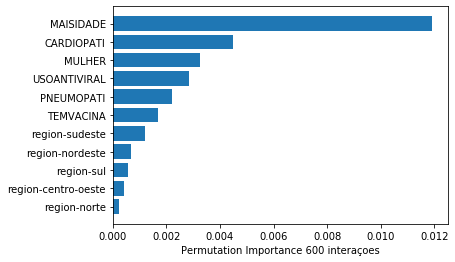

In [26]:
import matplotlib.pyplot as plt

sorted_idx = pii.importances_mean.argsort()
plt.barh(df_drop.columns[sorted_idx], pii.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance 20 interaçoes")

Text(0.5, 0, 'Permutation Importance 20 interaçoes [com vacina]')

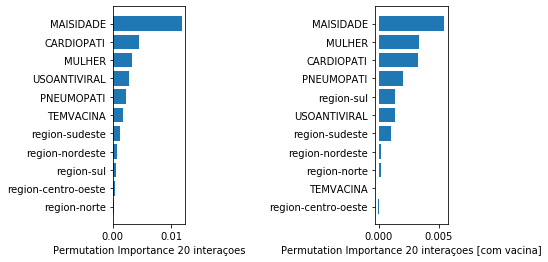

In [42]:
plt.subplot(141)
sorted_idx = pii.importances_mean.argsort()
plt.barh(df_drop.columns[sorted_idx], pii.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance 20 interaçoes")

plt.subplot(144)
sorted_idx_v = pii_v.importances_mean.argsort()
plt.barh(df_drop_v.columns[sorted_idx_v], pii_v.importances_mean[sorted_idx_v])
plt.xlabel("Permutation Importance 20 interaçoes [com vacina]")

Text(0.5, 0, 'Permutation Importance 600 interaçoes')

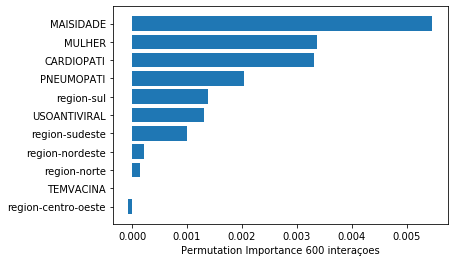

In [27]:
import matplotlib.pyplot as plt

sorted_idx = pii_v.importances_mean.argsort()
plt.barh(df_drop_v.columns[sorted_idx], pii_v.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance 20 interaçoes")

In [28]:
import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(rf, random_state=1).fit(raw_train_features, raw_train_mortes)
eli5.show_weights(perm, feature_names = feature_list)

Weight,Feature
0.0120 ± 0.0010,MAISIDADE
0.0046 ± 0.0008,CARDIOPATI
0.0033 ± 0.0003,MULHER
0.0030 ± 0.0009,USOANTIVIRAL
0.0023 ± 0.0002,PNEUMOPATI
0.0016 ± 0.0008,TEMVACINA
0.0010 ± 0.0008,region-sudeste
0.0008 ± 0.0004,region-nordeste
0.0006 ± 0.0008,region-sul
0.0004 ± 0.0004,region-centro-oeste


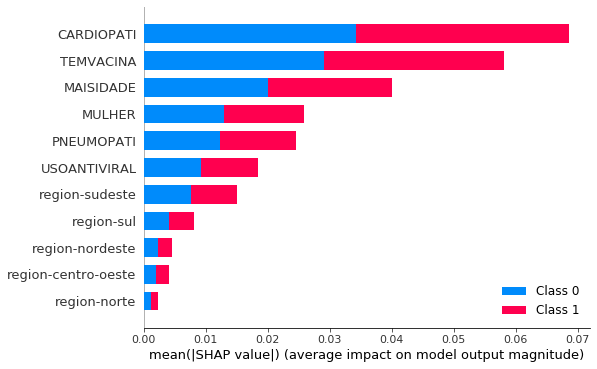

In [29]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(raw_train_features)
shap.summary_plot(shap_values, raw_train_features, plot_type="bar", feature_names = feature_list)

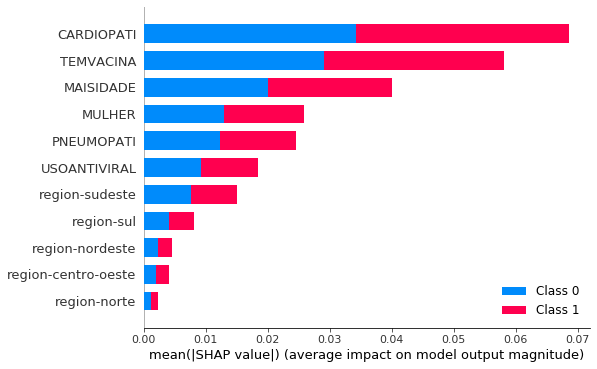

In [30]:
shap.summary_plot(shap_values, raw_train_features, feature_names = feature_list)

In [ ]:
feature_list